In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Progress bar

def modulate(bits, modulation):
    if modulation == 'BPSK':
        return 2 * bits - 1
    elif modulation == 'QPSK':
        symbols = bits.reshape(-1, 2)
        return (2 * symbols[:, 0] - 1) + 1j * (2 * symbols[:, 1] - 1)
    elif modulation == '16QAM':
        symbols = bits.reshape(-1, 4)
        return ((2 * symbols[:, 0] + symbols[:, 1] - 1.5) +
                1j * (2 * symbols[:, 2] + symbols[:, 3] - 1.5))
    elif modulation == '64QAM':
        symbols = bits.reshape(-1, 6)
        return ((4 * symbols[:, 0] + 2 * symbols[:, 1] + symbols[:, 2] - 3.5) +
                1j * (4 * symbols[:, 3] + 2 * symbols[:, 4] + symbols[:, 5] - 3.5))
    else:
        raise NotImplementedError(f"{modulation} not supported in this version.")

def awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    power = np.mean(np.abs(signal) ** 2)
    noise_power = power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

def generate_frame(modulation, snr_db, num_samples, num_rus):
    bits_per_symbol = {'BPSK': 1, 'QPSK': 2, '16QAM': 4, '64QAM': 6}[modulation]
    bits = np.random.randint(0, 2, num_samples * bits_per_symbol)
    signal = modulate(bits, modulation)
    frame_data = []

    for _ in range(num_rus):
        h = (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)  # Rayleigh fading
        received = h * signal
        noisy = awgn(received, snr_db)
        frame_data.append(noisy)

    return np.stack(frame_data), modulation

def build_dataset(modulations, snrs, num_frames, num_samples, num_rus):
    X, y = [], []
    for mod in tqdm(modulations, desc="Generating dataset by modulation"):
        for snr in tqdm(snrs, desc=f"{mod}", leave=False):
            for _ in range(num_frames):
                try:
                    frame, label = generate_frame(mod, snr, num_samples, num_rus)
                    X.append(frame)
                    y.append(mod)
                except NotImplementedError:
                    continue
    return np.array(X), np.array(y)

# Parameters
modulations = ['BPSK', 'QPSK', '16QAM', '64QAM']
snr_range = list(range(-10, 32, 2))  # -10 to 30 dB
num_frames_per_combo = 1024
samples_per_frame = 1024
num_rus = 3

# Generate dataset with progress bars
X, y = build_dataset(modulations, snr_range, num_frames_per_combo, samples_per_frame, num_rus)

# Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, train_size=0.75, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp)

# Save
# Use faster save
np.savez("modulation_dataset.npz", X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test,
         label_map=le.classes_)

print("✅ Dataset generation complete and saved to 'modulation_dataset.npz'")



Generating dataset by modulation: 100%|██████████████████████████████████████████████████| 4/4 [01:19<00:00, 19.82s/it]


✅ Dataset generation complete and saved to 'modulation_dataset.npz'


In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def equal_gain_combine(x):
    combined = np.sum(x, axis=1)  # [batch, iq_len]
    i = combined.real
    q = combined.imag
    return np.stack([i, q], axis=-1).reshape(x.shape[0], -1)  # [batch, 2*iq_len]

# Load and preprocess
data = np.load("modulation_dataset.npz")
le = LabelEncoder()
X_train = equal_gain_combine(data['X_train'])
X_val = equal_gain_combine(data['X_val'])
X_test = equal_gain_combine(data['X_test'])

y_train = tf.keras.utils.to_categorical(data['y_train'])
y_val = tf.keras.utils.to_categorical(data['y_val'])
y_test = tf.keras.utils.to_categorical(data['y_test'])


In [4]:
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_amc(input_shape, num_classes, num_stacks=5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(num_stacks):
        x = residual_block(x, 32)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

input_shape = (X_train.shape[1] // 2, 2)  # reshape for Conv1D: (samples, 2)
X_train = X_train.reshape(-1, input_shape[0], input_shape[1])
X_val = X_val.reshape(-1, input_shape[0], input_shape[1])
X_test = X_test.reshape(-1, input_shape[0], input_shape[1])

model = build_resnet_amc(input_shape, y_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1024, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 1024, 32)          │             224 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1024, 32)          │             128 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 1024, 32)          │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 1024, 32)          │           3,104 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 1024, 32)          │             128 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 1024, 32)          │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 1024, 32)          │           3,104 │ re_lu_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 1024, 32)          │             128 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1024, 32)          │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_2 (ReLU)                │ (None, 1024, 32)          │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 1024, 32)          │           3,104 │ re_lu_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 1024, 32)          │             128 │ conv1d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_3 (ReLU)                │ (None, 1024, 32)          │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 1024, 32)          │           3,10

 Total params: 37,412 (146.14 KB)

 Trainable params: 36,708 (143.39 KB)

 Non-trainable params: 704 (2.75 KB)

In [5]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 355s 334ms/step - accuracy: 0.5768 - loss: 0.9459 - val_accuracy: 0.6942 - val_loss: 0.6826
Epoch 2/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 327s 325ms/step - accuracy: 0.7095 - loss: 0.6496 - val_accuracy: 0.5805 - val_loss: 0.9511
Epoch 3/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 646s 641ms/step - accuracy: 0.7473 - loss: 0.5539 - val_accuracy: 0.6720 - val_loss: 0.7917
Epoch 4/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 240s 238ms/step - accuracy: 0.7626 - loss: 0.5148 - val_accuracy: 0.6950 - val_loss: 0.6903
Epoch 5/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 252s 250ms/step - accuracy: 0.7739 - loss: 0.4883 - val_accuracy: 0.7799 - val_loss: 0.4771
Epoch 6/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 302s 299ms/step - accuracy: 0.7723 - loss: 0.4820 - val_accuracy: 0.7794 - val_loss: 0.4827
Epoch 7/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 278s 276ms/step - accuracy: 0.7829 - loss: 0.4696 - val_accuracy: 0.7623 - val_loss: 0.5158
Epoch 8/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 286s 284ms/step - ac

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7804 - loss: 0.4769
✅ Test Accuracy: 77.86%


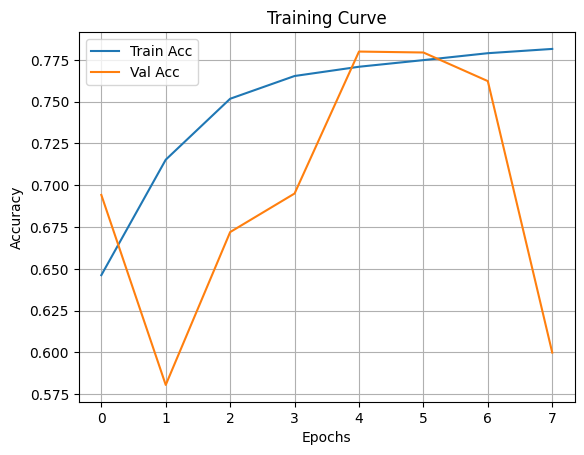

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_ru_model(input_shape, num_classes, num_stacks=3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(num_stacks):
        shortcut = x
        x = layers.Conv1D(32, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(32, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([shortcut, x])
        x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="RUModel")


In [9]:
# Shape: [frames, num_rus, samples] → [frames*num_rus, samples, 2]
X = data['X_train'].reshape(-1, data['X_train'].shape[-1])
X = np.stack([X.real, X.imag], axis=-1)
y = np.repeat(data['y_train'], 3)

# Train a shared RU model
input_shape = X.shape[1:]
y_cat = tf.keras.utils.to_categorical(y)

ru_model = build_ru_model(input_shape, y_cat.shape[1])
ru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ru_model.fit(X, y_cat, epochs=5, batch_size=64, validation_split=0.1)
ru_model.save("ru_model.h5")


Epoch 1/5
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 451s 164ms/step - accuracy: 0.6259 - loss: 0.8401 - val_accuracy: 0.7080 - val_loss: 0.6778
Epoch 2/5
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 461s 169ms/step - accuracy: 0.7312 - loss: 0.5963 - val_accuracy: 0.6986 - val_loss: 0.7284
Epoch 3/5
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 467s 172ms/step - accuracy: 0.7726 - loss: 0.4943 - val_accuracy: 0.7813 - val_loss: 0.5201
Epoch 4/5
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 509s 187ms/step - accuracy: 0.7968 - loss: 0.4434 - val_accuracy: 0.7967 - val_loss: 0.4756
Epoch 5/5
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 496s 182ms/step - accuracy: 0.8031 - loss: 0.4234 - val_accuracy: 0.7563 - val_loss: 0.5898


In [10]:
# Reload and freeze RU model
ru_model = tf.keras.models.load_model("ru_model.h5")
ru_model.trainable = False

def get_ru_outputs(X_raw):
    all_soft = []
    for i in range(3):  # 3 RUs
        x = X_raw[:, i]  # [frames, samples]
        x = np.stack([x.real, x.imag], axis=-1)  # [frames, samples, 2]
        preds = ru_model.predict(x, batch_size=64, verbose=0)
        all_soft.append(preds)
    return np.concatenate(all_soft, axis=-1)  # [frames, 3 * num_classes]

train_soft = get_ru_outputs(data['X_train'])
val_soft = get_ru_outputs(data['X_val'])
test_soft = get_ru_outputs(data['X_test'])

y_train = tf.keras.utils.to_categorical(data['y_train'])
y_val = tf.keras.utils.to_categorical(data['y_val'])
y_test = tf.keras.utils.to_categorical(data['y_test'])


In [18]:
def build_voting_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

voting_model = build_voting_model(train_soft.shape[1], y_train.shape[1])
voting_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

voting_model.fit(train_soft, y_train, validation_data=(val_soft, y_val), epochs=10, batch_size=64)

# Evaluate
test_acc2 = voting_model.evaluate(test_soft, y_test, verbose=0)[1]
print(f"✅ Test Accuracy (Distributed Model): {test_acc * 100:.2f}%")


Epoch 1/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8143 - loss: 0.5425 - val_accuracy: 0.8506 - val_loss: 0.3493
Epoch 2/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8564 - loss: 0.3320 - val_accuracy: 0.8546 - val_loss: 0.3286
Epoch 3/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8602 - loss: 0.3134 - val_accuracy: 0.8558 - val_loss: 0.3227
Epoch 4/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8602 - loss: 0.3080 - val_accuracy: 0.8571 - val_loss: 0.3179
Epoch 5/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8628 - loss: 0.3051 - val_accuracy: 0.8578 - val_loss: 0.3161
Epoch 6/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8623 - loss: 0.3022 - val_accuracy: 0.8579 - val_loss: 0.3124
Epoch 7/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8634 - loss: 0.2982 - val_accuracy: 0.8566 - val_loss: 0.3101
Epoch 8/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8625 - loss: 0.3004 - 

In [12]:
def build_du_model(input_shape, num_stacks=5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(num_stacks):
        shortcut = x
        x = layers.Conv1D(32, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(32, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([shortcut, x])
        x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(inputs, x, name="DUModel")


In [13]:
def get_egc_features(X_raw):
    # [frames, RUs, samples]
    combined = np.sum(X_raw, axis=1)
    combined = np.stack([combined.real, combined.imag], axis=-1)  # [frames, samples, 2]
    return combined

# DU input: [frames, samples, 2]
X_du_train = get_egc_features(data['X_train'])
X_du_val = get_egc_features(data['X_val'])
X_du_test = get_egc_features(data['X_test'])

# Reuse soft decisions from RU
train_soft = get_ru_outputs(data['X_train'])
val_soft = get_ru_outputs(data['X_val'])
test_soft = get_ru_outputs(data['X_test'])


In [14]:
# Build DU model and freeze if pretrained
du_model = build_du_model(input_shape=(X_du_train.shape[1], 2))
du_model.compile(optimizer='adam', loss='mse')
du_model.summary()

# Optionally: Pretrain DU model on y_train, save, and reload

# Inputs
inp_du = layers.Input(shape=(X_du_train.shape[1], 2))     # IQ input
inp_soft = layers.Input(shape=(train_soft.shape[1],))      # Soft decision

# Process
feat_du = du_model(inp_du)
concat = layers.Concatenate()([feat_du, inp_soft])
x = layers.Dense(128, activation='relu')(concat)
out = layers.Dense(y_train.shape[1], activation='softmax')(x)

hybrid_model = models.Model(inputs=[inp_du, inp_soft], outputs=out)
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "DUModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 1024, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_18 (Conv1D)            │ (None, 1024, 32)          │             224 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 1024, 32)          │             128 │ conv1d_18[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_18 (ReLU)               │ (None, 1024, 32)          │               0 │ batch_normalization_18[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_19 (Conv1D)            │ (None, 1024, 32)          │           3,104 │ re_lu_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_19        │ (None, 1024, 32)          │             128 │ conv1d_19[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_19 (ReLU)               │ (None, 1024, 32)          │               0 │ batch_normalization_19[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_20 (Conv1D)            │ (None, 1024, 32)          │           3,104 │ re_lu_19[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_20        │ (None, 1024, 32)          │             128 │ conv1d_20[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_8 (Add)                   │ (None, 1024, 32)          │               0 │ re_lu_18[0][0],            │
│                               │                           │                 │ batch_normalization_20[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_20 (ReLU)               │ (None, 1024, 32)          │               0 │ add_8[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_21 (Conv1D)            │ (None, 1024, 32)          │           3,104 │ re_lu_20[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_21        │ (None, 1024, 32)          │             128 │ conv1d_21[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_21 (ReLU)               │ (None, 1024, 32)          │               0 │ batch_normalization_21[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_22 (Conv1D)            │ (None, 1024, 32)          │           3,10

 Total params: 36,896 (144.12 KB)

 Trainable params: 36,192 (141.38 KB)

 Non-trainable params: 704 (2.75 KB)

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

hybrid_model.fit(
    [X_du_train, train_soft], y_train,
    validation_data=([X_du_val, val_soft], y_val),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 265s 255ms/step - accuracy: 0.7956 - loss: 0.5341 - val_accuracy: 0.8442 - val_loss: 0.3401
Epoch 2/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 267s 265ms/step - accuracy: 0.8600 - loss: 0.3099 - val_accuracy: 0.8526 - val_loss: 0.3276
Epoch 3/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 250s 248ms/step - accuracy: 0.8624 - loss: 0.3030 - val_accuracy: 0.8557 - val_loss: 0.3139
Epoch 4/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1146s 1s/step - accuracy: 0.8638 - loss: 0.2956 - val_accuracy: 0.8557 - val_loss: 0.3251
Epoch 5/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 6817s 7s/step - accuracy: 0.8655 - loss: 0.2937 - val_accuracy: 0.8630 - val_loss: 0.2994
Epoch 6/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 247s 245ms/step - accuracy: 0.8650 - loss: 0.2918 - val_accuracy: 0.8599 - val_loss: 0.3044
Epoch 7/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 257s 255ms/step - accuracy: 0.8678 - loss: 0.2856 - val_accuracy: 0.8619 - val_loss: 0.3103
Epoch 8/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 246s 244ms/step - accura

In [16]:
loss, acc = hybrid_model.evaluate([X_du_test, test_soft], y_test, verbose=0)
print(f"✅ Hybrid Model Test Accuracy: {acc * 100:.2f}%")


✅ Hybrid Model Test Accuracy: 86.53%


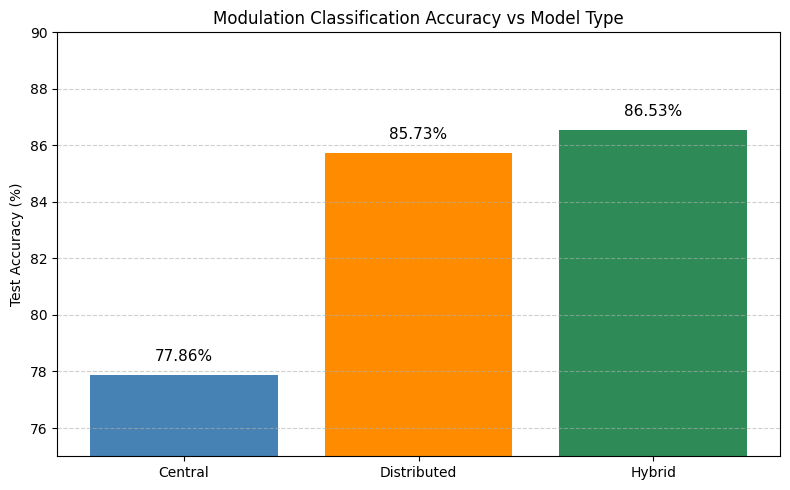

In [21]:
import matplotlib.pyplot as plt

# Your actual results
model_types = ['Central', 'Distributed', 'Hybrid']
accuracies = [77.86, 85.73, 86.53]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_types, accuracies, color=['steelblue', 'darkorange', 'seagreen'])
plt.ylabel("Test Accuracy (%)")
plt.title("Modulation Classification Accuracy vs Model Type")
plt.ylim(75, 90)

# Annotate values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}%", ha='center', fontsize=11)

plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.tight_layout()
plt.show()
